In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import sys
import re
from pathlib import Path
from collections import OrderedDict

import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import pandas as pd
import importlib.util

# ================= USER CONFIG =================
MODEL_PATH = "/content/drive/MyDrive/model.py"
MODEL_CLASS = "ConvNeXt"                                # your class name in model.py
CHECKPOINT_PATH = "/content/drive/MyDrive/best.pt"
TEST_DIR = "/content/drive/MyDrive/test"
OUTPUT_CSV = "/content/drive/MyDrive/submission1.csv"

VARIANT = "tiny"   # choose from: "tiny", "small", "base", "large"
IMG_SIZE = (224, 224)
NUM_CLASSES = 2
BATCH_SIZE = 64
NUM_WORKERS = 0
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# ========================================

# ConvNeXt standard configs (Meta/torchvision style)
VARIANT_CONFIG = {
    "tiny":  {"depths": [3, 3, 9, 3],  "dims": [96, 192, 384, 768]},
    "small": {"depths": [3, 3, 27, 3], "dims": [96, 192, 384, 768]},
    "base":  {"depths": [3, 3, 27, 3], "dims": [128, 256, 512, 1024]},
    "large": {"depths": [3, 3, 27, 3], "dims": [192, 384, 768, 1536]},
}

print("Imports, configurations, and variant config defined.")

Imports, configurations, and variant config defined.


In [2]:
import importlib.util

#  dynamic import of your model.py
spec = importlib.util.spec_from_file_location("user_model", MODEL_PATH)
user_model = importlib.util.module_from_spec(spec)
spec.loader.exec_module(user_model)
ConvNeXt = getattr(user_model, MODEL_CLASS)

print(f"Dynamically imported model class: {MODEL_CLASS} from {MODEL_PATH}")

Dynamically imported model class: ConvNeXt from /content/drive/MyDrive/model.py


In [3]:
import re
import os
from pathlib import Path
from collections import OrderedDict

import torch
from PIL import Image

#  natural sort for filenames like 1.jpg, 2.jpg
def natural_key(s):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r"(\d+)", s)]

# ---- simple unlabeled dataset ----
class UnlabeledImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [
            f for f in os.listdir(image_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        self.image_files.sort(key=natural_key)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        fname = self.image_files[idx]
        img_path = os.path.join(self.image_dir, fname)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, fname

print("natural_key function and UnlabeledImageDataset class defined.")

natural_key function and UnlabeledImageDataset class defined.


In [4]:
from torchvision import transforms

#  test-time transforms (no random aug)
transform_test = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

print("Test-time transforms (transform_test) defined.")

Test-time transforms (transform_test) defined.


In [5]:
import torch
import torch.nn as nn
from collections import OrderedDict

#  build model: handle (no-arg) and (depths/dims) styles
def build_convnext():
    try:
        # Try no-arg constructor first (some repos wrap variant internally)
        model = ConvNeXt()
    except TypeError as e:
        # Fallback: pass variant config if required
        if ("depths" in str(e) and "dims" in str(e)) or ("positional arguments" in str(e)):
            cfg = VARIANT_CONFIG[VARIANT]
            model = ConvNeXt(depths=cfg["depths"], dims=cfg["dims"], num_classes=NUM_CLASSES) \
                if "num_classes" in ConvNeXt.__init__.__code__.co_varnames \
                else ConvNeXt(depths=cfg["depths"], dims=cfg["dims"])
        else:
            raise

    # Make sure final classifier outputs NUM_CLASSES
    # Common ConvNeXt heads use model.classifier[-1] as nn.Linear
    if hasattr(model, "classifier"):
        last = model.classifier[-1]
        if isinstance(last, nn.Linear) and last.out_features != NUM_CLASSES:
            in_f = last.in_features
            model.classifier[-1] = nn.Linear(in_f, NUM_CLASSES)
    elif hasattr(model, "head"):
        # some repos name it head
        last = model.head
        if isinstance(last, nn.Linear) and last.out_features != NUM_CLASSES:
            in_f = last.in_features
            model.head = nn.Linear(in_f, NUM_CLASSES)
    # else: keep as defined in your model.py
    return model

# ---- load checkpoint robustly ----
def load_weights(model, path):
    ckpt = torch.load(path, map_location="cpu")
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        state_dict = ckpt["model_state_dict"]
    elif isinstance(ckpt, dict) and "state_dict" in ckpt:
        state_dict = ckpt["state_dict"]
    else:
        state_dict = ckpt

    new_state = OrderedDict()
    for k, v in state_dict.items():
        new_k = k.replace("module.", "")
        new_state[new_k] = v

    model.load_state_dict(new_state, strict=False)
    return model

print("build_convnext and load_weights functions defined.")

build_convnext and load_weights functions defined.


In [8]:
print(model)

ConvNeXt(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d(
        (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      )
    )
    (1): Sequential(
      (0): LayerNorm2d(
        (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Sequential(
      (0): LayerNorm2d(
        (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      )
      (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): LayerNorm2d(
        (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      )
      (1): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): ConvNeXtBlock(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (norm): LayerNo

Displaying 10 randomly selected images with their predictions:



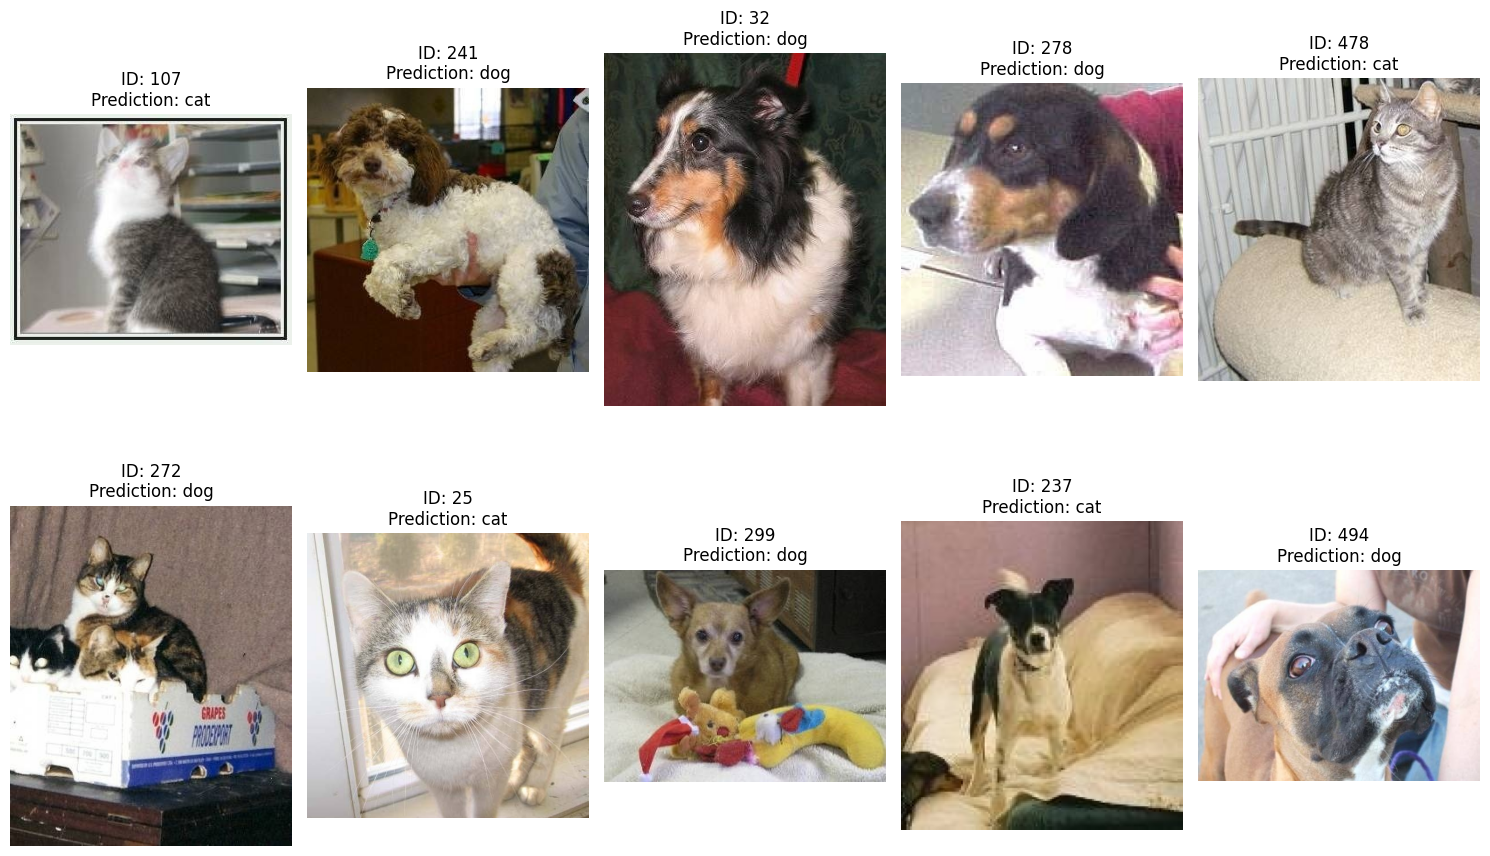

In [9]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Get all image files from the dataset
all_image_files = ds.image_files

# Randomly sample 10 image filenames
num_samples = 10
if len(all_image_files) < num_samples:
    num_samples = len(all_image_files)

sampled_filenames = random.sample(all_image_files, k=num_samples)

print(f"Displaying {num_samples} randomly selected images with their predictions:\n")

# Create a figure to display images
plt.figure(figsize=(15, 10))

for i, fname in enumerate(sampled_filenames):
    img_path = os.path.join(TEST_DIR, fname)
    original_image = Image.open(img_path).convert("RGB")

    # Apply test transformations
    transformed_image = transform_test(original_image)

    # Add batch dimension and move to device for inference
    input_image = transformed_image.unsqueeze(0).to(DEVICE)

    # Perform inference
    with torch.no_grad():
        logits = model(input_image)
        pred_idx = torch.argmax(logits, dim=1).item()

    # Get the predicted label string
    label_map = {0: "cat", 1: "dog"}
    predicted_label = label_map[pred_idx]

    # Display the image and its prediction
    plt.subplot(2, 5, i + 1) # Adjust subplot grid as needed
    plt.imshow(original_image) # Display original image for better visualization
    plt.title(f"ID: {Path(fname).stem}\nPrediction: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import torch
from pathlib import Path

# ===== run inference =====
model = build_convnext()
model = load_weights(model, CHECKPOINT_PATH)
model = model.to(DEVICE).eval()

ds = UnlabeledImageDataset(TEST_DIR, transform=transform_test)
dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

ids, preds = [], []
with torch.no_grad():
    for images, names in dl:
        images = images.to(DEVICE)
        logits = model(images)
        pred = torch.argmax(logits, dim=1).cpu().tolist()
        for name, p in zip(names, pred):
            ids.append(Path(name).stem)
            preds.append(int(p))

label_map = {0: "cat", 1: "dog"}
preds_str = [label_map[p] for p in preds]
df = pd.DataFrame({"id": ids, "label": preds_str})

# keep numeric order if ids are numbers
try:
    df["id_num"] = df["id"].astype(int)
    df = df.sort_values("id_num").drop(columns=["id_num"])
except ValueError:
    pass

df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved {len(df)} rows to {OUTPUT_CSV}")


Saved 500 rows to /content/drive/MyDrive/submission1.csv
